# Learning music with a RNN - episode 1: the dataset

In this project I will teach a Recurrent Neural Network (specifically a Long Short Term Memory network) how to generate meaningful sequences of guitar chords.

By crawling the internet I put together a dataset of around 300 thousand guitar chord sequences. I gathered them from open access websites where users upload transcriptions of popular songs for free.

Such a large dataset is no match for the computing power at my disposal, so I need to select a meaningful subset. I then decided to get the list of the best 100 rock artists according to Rolling Stones, from [here](https://www.rollingstone.com/music/music-lists/100-greatest-artists-147446), and I selected their songs, so the RNN will learn not just any song, but the best music out there ;-)

In order to avoid copyright issues, I only saved the sequence of chords, but not the title, the artist nor any other information that would allow to link a chord sequence to a particular song.

### Selecting dataset

Let's load the raw data in a pandas Series:

In [1]:
import pandas as pd
from chords_ai.package_data import get_path_of_data_file

# Read corpus
chords_orig = pd.read_json(get_path_of_data_file("best_artists_chords_anonymous.json"), 
                           typ='series', orient='split')

print("There are %s songs in the dataset" % len(chords_orig))

Using TensorFlow backend.


There are 8009 songs in the dataset


These sequences of chords were uplodaded by users in free form pages, i.e., no formatting was enforced on them and no chord recognition was applied. This means that the raw dataset is pretty messy and we need to standardize it before we can use. Here is a list of things that we need to change:

1. The same chord is expressed in different ways (for example, a B minor can be called Bm, B-). We need to fix that and use always the same notation for the same chord.
2. Alterations such as [accidentals](https://en.wikipedia.org/wiki/Accidental_(music) are sometimes used after the name of the chord ("Bbm") sometimes in other places ("Bmb"). We need to standardize this by placing the accidental immediately after the name of the chord.
3. There is no clear concept of musical [bars](https://goo.gl/C6BYba), thus certain authors choose to repeat the same chords multiple times to mean "two bars of C" ("C C") while some others just put one "C" meaning that it should be played until the next chord comes along. For this reason, we will not try to learn the concept of bar and how to use it. Instead, we will remove every repetitions of chords, so "C C" -> "C"

Moreover, the unique number of chords used is very large, because chords can be arbitrarily complicated. However, if a chord is used only a few times in the entire corpus, our RNN will not be able to learn when to use it. We are then going to apply some [stemming](https://en.wikipedia.org/wiki/Stemming) to reduce the number of chords to a manageable level. 

The following functions uses [regular expressions](https://en.wikipedia.org/wiki/Regular_expression) and transformations to apply all the fixes and simplifications to our raw dataset. Comments in the code describe all the transformations applied:

In [2]:
from chords_ai.stemming import stem

songs = chords_orig.apply(stem)

There are some songs where one or more chords were not recognized at all. These were substituted with an empty string. Let's remove them from the sample:

In [3]:
import numpy as np

n_songs_raw = songs.shape[0]

# Remove songs containing non-recognized chords
songs.replace('', np.nan, inplace=True)
songs.dropna(inplace=True)

# Let's see how many we lost
n_songs = songs.shape[0]
print("Removed %i songs (%.3g percent)" % (n_songs_raw - n_songs, 
                                           (n_songs_raw - n_songs)/ float(n_songs) * 100))
print("Songs remaining: %s" % n_songs)

Removed 907 songs (12.8 percent)
Songs remaining: 7102


## Most common chords

Now that we have a clean sample we can gain some interesting insights.

Let's start by counting the number of unique chords we have:

In [4]:
# Concatenate all songs, split them in chords, and then
# apply the unique function
all_chords_sequentially = songs.str.cat(sep=" ")
all_chords_separatedly = all_chords_sequentially.split(" ")
print("%i unique chords, %i chords total" % (np.unique(all_chords_separatedly).shape[0],
                                             len(all_chords_separatedly)))

373 unique chords, 450346 chords total


Let's now plot how many times a given chord appears in our dataset (most common first):

<IPython.core.display.Javascript object>


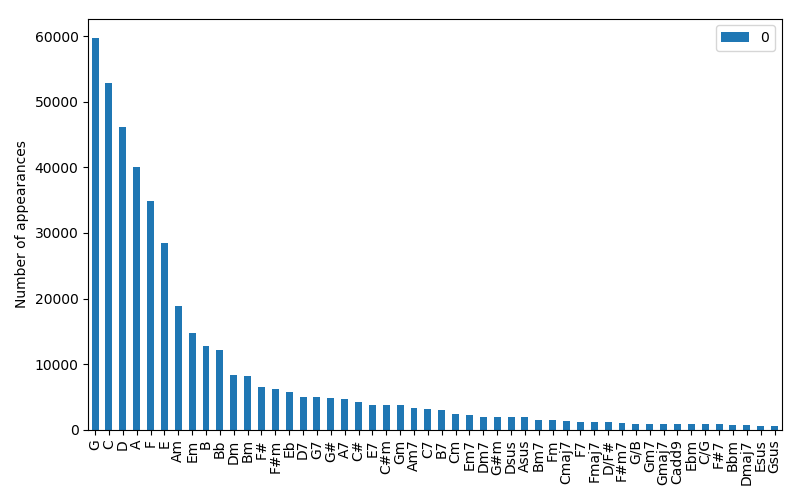

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt

from collections import Counter

# Count how many times each chord appears
chords_counts = Counter(all_chords_separatedly)

# Make dataframe and order by number of appearences
df = pd.DataFrame.from_dict(chords_counts, orient='index')
df.sort_values(0, inplace=True, ascending=False)

# Plot the first 50
fig, sub = plt.subplots(1,1,figsize=(8, 5))
df.iloc[0:50].plot(kind='bar', ax=sub)

plt.ylabel("Number of appearances")

plt.tight_layout()

G is by far the most used chord, followed by C, D, A F. The frequency of use of the chords decreases steeply going from left to right.

Perhaps a more interesting quantity is the number of *songs* containing a given chord (either one or multiple times). If you are just learning how to play guitar, these are the chords you want to learn!

<IPython.core.display.Javascript object>


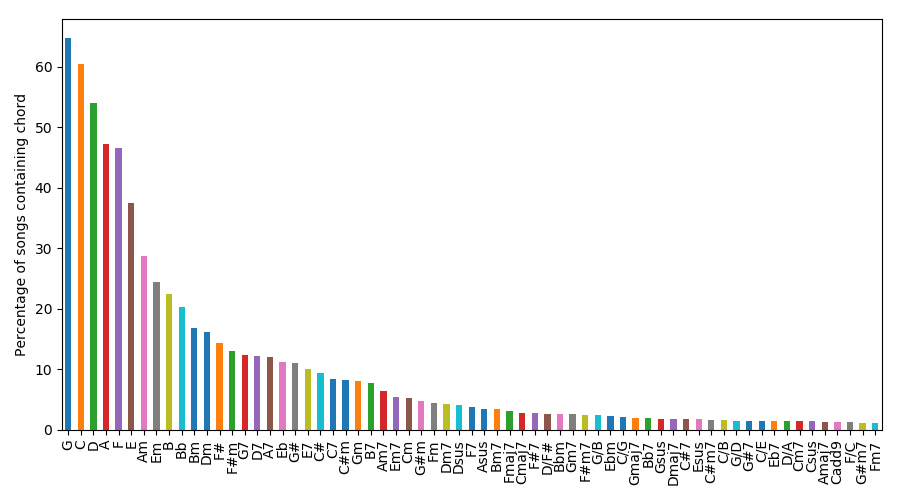

65 chords appear in at least 1 percent of the songs


In [40]:
class ChordFinder(object):
    
    def __init__(self, chord_to_find):
        
        self._chord_to_find = chord_to_find
    
    def __call__(self, row):
                
        chords = row.split()
        
        return self._chord_to_find in chords

# Counts how many songs contain each chord
songs_counts = {}

for i, chord in enumerate(np.unique(all_chords_separatedly)):
    
    # Find all songs containing this chord
    # The first regular expression matches the chord at the beginning
    # of the string or in the middle (followed by a space),
    # the second regular expression matches the chord at the end of the string.
    # This is necessary to distinguish chords like "D/F" and "D/F#"
    #idx = songs.str.match("^.*%s " % chord) | songs.str.match(".* %s$" % chord)
        
    idx = songs.apply(ChordFinder(chord))
    
    assert idx.shape[0] == songs.shape[0]
    
    songs_counts[chord] = np.sum(idx)
    
# Make a new dataframe
songdf = pd.DataFrame.from_dict(songs_counts, orient='index')
# Compute the frequency
# (number of songs in which the chord appear divided by the 
# total number of songs, multiplied by 100)
songdf['freq'] = songdf / float(songs.shape[0]) * 100
# Sort by frequency (most frequent first)
songdf.sort_values('freq', inplace=True, ascending=False)

# Plot
fig, sub = plt.subplots(1,1,figsize=(9, 5))

# Select chords that are at least in 1% of the songs
idx = songdf.freq > 1
print("%i chords appear in at least 1 percent of the songs" % np.sum(idx))

songdf[idx].loc[:, 'freq'].plot(kind='bar', ax=sub)

sub.set_ylabel("Percentage of songs containing chord")

plt.tight_layout()

Here we can see that the G chord appears in a staggering 65 percent of the songs! Followed at close distance by C, D, A, F and E. The frequency of usage decrease pretty sharply for the first few chords, then it flattens out. Therefore, there are few chords used very frequently and many chords used rarely.

## Final sample

The chords we just found, contained in at least 1 percent of the songs, are going to be our vocabulary, i.e., we will teach the RNN when to use them. All the others are too rare in our sample for the RNN to learn them.

Let's then select only the songs containing the chords in our vocabulary, and write sample and vocabulary to disk:

In [41]:
# Select the songs that contains only chords within the subset we selected earlier

# Make a set with only the chords used in at least 1% of the songs
vocabulary = songdf.index[idx].values
vs = set(vocabulary)

# Make a mask all False, we will change the songs selected
# to True
selected_idx = np.zeros(songs.shape[0], bool)

for i, song in enumerate(songs):
        
    # Make a set of chords within this song
    this_song_chords = set(song.split())
    
    if this_song_chords.issubset(vs):
        
        # This song only uses chords from the vocabulary
        selected_idx[i] = True

print("We selected %i songs" % songs[selected_idx].shape[0])

# We can finally write our cleaned data frame and we are ready to go!
final_sample = songs[selected_idx]

final_sample.to_json("best_songs_cleaned.json")

# Let's also write the vocabulary
import json

with open("best_songs_vocabulary.json", "w+") as ff:
    
    # Write the vocabulary in alphabetical order
    json.dump(list(sorted(vs)), ff)

We selected 5678 songs


Thus our final sample contains 5678 songs.